<a href="https://colab.research.google.com/github/adimemes/Analysisi-Sentimen/blob/main/Analysis_Sentimen_Mobile_Legend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis Sentimen Mobile Legend

## Instal Package Libary Sastrawi dan Google play scaper


*   ```Sastrawi``` membantu menyederhanakan kata-kata yang mengalami infleksi dalam Bahasa Indonesia ke bentuk dasarnya
*   ```Google play scaper``` Membantu untuk Scraping data di Google play store
*   ```gensim``` digunakan untuk pemrosesan teks dan pemodelan topik terutama Word Embeddings seperti ```Word2Vec```



In [ ]:
!pip install sastrawi
!pip install google-play-scraper
!pip install gensim

### Import Libary yang dibutuhkan

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import re
import string
import nltk
import csv
import requests

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from io import StringIO
from gensim.models import Word2Vec
from google_play_scraper import app, reviews, Sort, reviews_all
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud

pd.options.mode.chained_assignment = None
seed = 0
np.random.seed(seed)
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Scraping Data Di Playstore

Tahapan ini adalah tahapan untuk scraping data pada aplikasi Google Playstore, aplikasi yang diambil adalah Game Mobile Legend dengan rincian.


*   ```com.mobile.legends``` id aplikasi mobile legend dalam playstore
*   ```lang='id'``` Mengambil Review yang menggunakan bahasa indonesia
*   ```country='id'``` Mengambil review di negara indonesia
*   ```sort=Sort.MOST_RELEVANT``` Membuat data sesuai Urutan ulasan
*   ```count=5000``` Mengambil data sebanyak 5000 data

Kemudian setelah mendapatkan data tersebut lalu menyimpannya kedalam data yang berbentuk csv dengan header colomnya yaitu ```Review```



In [ ]:
scrapreview = reviews_all(
    'com.mobile.legends',
    lang='id',             # 'id' mengambil review yang berbahasa indonsesia
    country='id',          # 'id' mengambil yang negara indonesia
    sort=Sort.MOST_RELEVANT,
    count=5000
)

with open('Scraping_ML_Dataset.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['Review'])
    for review in scrapreview:
        writer.writerow([review['content']])

In [ ]:
ML_review = pd.DataFrame(scrapreview)
ML_review.shape
ML_review.head()
ML_review.to_csv('/content/Scraping_ML_Dataset.csv', index=False)

# Membuat DataFrame dari hasil scrapreview
ML_reviews = pd.DataFrame(scrapreview)

# Menghitung jumlah baris dan kolom dalam DataFrame
jumlah_data, jumlah_kolom = ML_reviews.shape
print(f"Jumlah baris dan kolom: {jumlah_data}, {jumlah_kolom}")

Jumlah baris dan kolom: 126000, 11


## EDA (Exploratory Data Analysis)

In [ ]:
ML_review.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,ea63a4a4-f9db-4df5-9ac8-dc2233074530,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Tolong pihak developer, match nya yg seimbang ...",2,1264,1.9.70.10634,2025-05-09 16:07:35,None,NaT,1.9.70.10634
1,829493a2-0ca9-4d4a-89f9-6a9184a1bd92,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,2 tahun ini para pemain mengeluhkan dark siste...,1,2549,1.9.70.10634,2025-05-18 17:46:59,None,NaT,1.9.70.10634
2,c6e8ce46-8f1e-4301-bb08-7b87e44e224a,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Gimana sih ni ada BUG PERTANDINGAN TIDAK DITEM...,1,579,1.9.70.10634,2025-05-16 03:08:25,None,NaT,1.9.70.10634
3,e1b961db-6b3d-4eec-afd4-6108aa44c67a,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"sesuaikan gameplay, jaringan padahal bagus, pe...",5,3083,1.9.70.10634,2025-05-16 02:55:52,None,NaT,1.9.70.10634
4,9f6b521f-afd3-4cf7-9a7f-d2a0acb6c43f,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"event collab naruto kali ini bagus, beneran ng...",5,103,1.9.72.10636,2025-05-22 14:35:15,None,NaT,1.9.72.10636


Awal adalah melihat data yang ada di dataset, terlihat pada kolom ini banyak terdapat data yang memiliki nilai None, NaT. kemungkinan pada data ini banyak yang memiliki missing value

In [ ]:
ML_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126000 entries, 0 to 125999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   reviewId              126000 non-null  object        
 1   userName              126000 non-null  object        
 2   userImage             126000 non-null  object        
 3   content               126000 non-null  object        
 4   score                 126000 non-null  int64         
 5   thumbsUpCount         126000 non-null  int64         
 6   reviewCreatedVersion  103446 non-null  object        
 7   at                    126000 non-null  datetime64[ns]
 8   replyContent          6684 non-null    object        
 9   repliedAt             6684 non-null    datetime64[ns]
 10  appVersion            103446 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 10.6+ MB


Terlihat pada info data, adanya data yang jomplang pada setiap kolom dataset yang mengakibatkan bisa merusak Analysis nantinya

### Memeriksa Missing Value dari dataset

In [ ]:
ML_review.isnull().sum()

,0
reviewId,0
userName,0
userImage,0
content,0
score,0
thumbsUpCount,0
reviewCreatedVersion,22554
at,0
replyContent,119316
repliedAt,119316


Terlihat pada data ini banyak sekali data yang memiliki missing Value

### Cleaning Data

Tahap awal yang dilakukan adalah membuat Dataframe baru yaitu ```ML_review_clean``` untuk menyimpan dataset yang sudah dibersihkan pada tahap awal adalah menghapus data yang memiliki nilai missing value dengan code
```.dropna()```

In [ ]:
ML_review_clean = ML_review.dropna()

In [ ]:
# Menghapus baris duplikat dari DataFrame ML_review_clean
ML_review_clean = ML_review_clean.drop_duplicates()

# Menghitung jumlah baris dan kolom dalam DataFrame ML_review_clean setelah menghapus duplikat
Jumlah_clean_data, Jumlah_clean_kolom = ML_review_clean.shape

In [ ]:
print(f"Jumlah baris dan kolom sebelum penghapusan duplikat: {jumlah_data}, {jumlah_kolom}")
print(f"Jumlah baris dan kolom setelah penghapusan duplikat: {Jumlah_clean_data}, {Jumlah_clean_kolom}")

Jumlah baris dan kolom sebelum penghapusan duplikat: 126000, 11
Jumlah baris dan kolom setelah penghapusan duplikat: 5679, 11


In [ ]:
ML_review_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5679 entries, 5 to 125999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              5679 non-null   object        
 1   userName              5679 non-null   object        
 2   userImage             5679 non-null   object        
 3   content               5679 non-null   object        
 4   score                 5679 non-null   int64         
 5   thumbsUpCount         5679 non-null   int64         
 6   reviewCreatedVersion  5679 non-null   object        
 7   at                    5679 non-null   datetime64[ns]
 8   replyContent          5679 non-null   object        
 9   repliedAt             5679 non-null   datetime64[ns]
 10  appVersion            5679 non-null   object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 532.4+ KB


## Data Preprocessing Text

In [ ]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka

    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text

def casefoldingText(text): # Mengubah semua karakter dalam teks menjadi huruf kecil
    text = text.lower()
    return text

def tokenizingText(text): # Memecah atau membagi string, teks menjadi daftar token
    text = word_tokenize(text)
    return text

def filteringText(text): # Menghapus stopwords dalam teks
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','gk','yaa','gak','nya','na','sih','ku','di','ga','dll','gaa','loh','kah','woi','woii','woy',
                          'aja', 'deh', 'dong', 'nih', 'tuh', 'kok', 'lah', 'pun', 'gitu', 'banget'])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text): # Mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join(word for word in list_words)
    return sentence

Pada tahapan ini ada beberapa step yaitu :


*   ```cleaningText``` dimana pada tahapan ini yaitu memperbaiki text dengan cara menghapus mention,hastang dan beberapa karakter yang tidak perlu dalam procesing data
*   ```casefolding``` dalam tahap ini adalah mengubah semua katakter dalam text menjadi huruf kecil
*   ```tokenizingText``` tahapan ini adalah membagi strung menjadi text daftar token
*   ```filteringText``` tahapan ini adalah menghapus stopwords dalam tesk, dimana mengisi list kata yang akan digunakan untuk stopwords
*   ```stemmingText``` Mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata
*   ```toSentence``` Mengubah daftar kata menjadi kalimat



In [ ]:
slangwords = {"@": "di","abis": "habis", "masi": "masih", "bgt": "banget", "maks": "maksimal", "noob": "pemain pemula","gg": "good game",
              "feed": "mati terus", "feeder": "pemain yang mati terus", "afk": "meninggalkan permainan", "troll": "bermain asal",
              "carry": "menggendong tim", "ngelag": "koneksi buruk", "lag": "koneksi lambat", "op": "terlalu kuat", "nerf": "dilemahkan",
              "buff": "diperkuat", "push": "menyerang", "rank": "peringkat", "ml": "mobile legends", "mlbb": "mobile legends",
              "auto win": "pasti menang", "auto lose": "pasti kalah", "bocil": "anak kecil", "toxic": "berkata kasar", "idiot": "bodoh",
              "fix": "pasti", "anjir": "astaga", "anjay": "wow", "bangsat": "kasar", "kampret": "kesal","gk": "tidak","ga": "tidak",
              "ngga": "tidak","nggak": "tidak","gak": "tidak","bngt": "banget","bener": "benar","parah": "buruk","udah": "sudah",
              "dah": "sudah","bikin": "membuat","goblok": "bodoh","ngerti": "mengerti","ngambek": "marah","cape": "lelah","capek": "lelah",
              "btw": "ngomong-ngomong", "kwkw": "tertawa","wkwk": "tertawa","wkwwk": "tertawa","lol": "tertawa","ihh": "heran","pake": "pakai",
              "maen": "main", "mainin": "mainkan","tim": "team","temen": "teman", "ngekill": "membunuh","kill": "bunuh","titid": "jelek",
              }


In [ ]:
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

Dua Cell di atas adalah tahapan membersihkan slangword yang ada dalam dataset dan dirubah ke kata yang benar, kemudian pada ```fix_slangwords``` kata yang diperbaiki di atas akan disimpan ke dalam data

In [ ]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
ML_review_clean['text_clean'] = ML_review_clean['content'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
ML_review_clean['text_casefoldingText'] = ML_review_clean['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
ML_review_clean['text_slangwords'] = ML_review_clean['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
ML_review_clean['text_tokenizingText'] = ML_review_clean['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
ML_review_clean['text_stopword'] = ML_review_clean['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
ML_review_clean['text_akhir'] = ML_review_clean['text_stopword'].apply(toSentence)

Pada Cell di atas ini adalah memasukan data ke dalam dataset seperti, <br>

*   memasukan data ```text_clean``` ke dalam dataset
*   memasukan data ```text_casefoldingText``` ke dalam dataset
*   memasukan data ```text_slangwords``` ke dalam dataset
*   memasukan data ```text_tokenizingText``` ke dalam dataset
*   memasukan data ```text_stopword``` ke dalam dataset
*   memasukan data ```text_akhir``` ke dalam dataset





In [ ]:
ML_review_clean

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
5,d90a8fdf-16b0-4788-863e-e3791553bced,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,kok jaringannya gini sih pas mau ngekill tiba2...,1,407,1.9.70.10634,2025-05-18 06:38:34,"Halo Kak,\nMaaf atas masalah jaringan yang Kak...",2025-05-18 07:10:08,1.9.70.10634,kok jaringannya gini sih pas mau ngekill tiba ...,kok jaringannya gini sih pas mau ngekill tiba ...,kok jaringannya gini sih pas mau membunuh tiba...,"[kok, jaringannya, gini, sih, pas, mau, membun...","[jaringannya, gini, pas, membunuh, koneksi, bu...",jaringannya gini pas membunuh koneksi buruk ku...
20,57a0b586-2d3e-4891-8abf-d95d007f604f,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Game titid!!!, Suka hilang koneksi tiba2 padah...",1,61,1.9.70.10634,2025-05-21 00:29:19,"Halo Kak,\nMaaf atas masalah jaringan yang Kak...",2025-05-21 02:54:46,1.9.70.10634,Game titid Suka hilang koneksi tiba padahal pi...,game titid suka hilang koneksi tiba padahal pi...,game jelek suka hilang koneksi tiba padahal pi...,"[game, jelek, suka, hilang, koneksi, tiba, pad...","[game, jelek, suka, hilang, koneksi, ping, ijo...",game jelek suka hilang koneksi ping ijo lagnya...
42,262eb85f-b766-4c87-89b9-24041d92571c,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Moonton nggak jelas banget,, gue susah2 nyari ...",1,96,1.9.70.10634,2025-05-16 21:21:37,"Halo Kak,\nKami berkomitmen untuk menciptakan ...",2024-11-29 03:43:31,1.9.70.10634,Moonton nggak jelas banget gue susah nyari men...,moonton nggak jelas banget gue susah nyari men...,moonton tidak jelas banget gue susah nyari men...,"[moonton, tidak, jelas, banget, gue, susah, ny...","[moonton, gue, susah, nyari, menang, eh, team,...",moonton gue susah nyari menang eh team team mu...
45,94f13107-096a-4446-a0ab-12380721b207,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"kenapa makin kesini makin menjadi ini game,mas...",1,136,1.9.64.10601,2025-04-27 00:03:05,"Halo Kak,\nMaaf atas masalah jaringan yang Kak...",2025-04-27 02:31:06,1.9.64.10601,kenapa makin kesini makin menjadi ini gamemasa...,kenapa makin kesini makin menjadi ini gamemasa...,kenapa makin kesini makin menjadi ini gamemasa...,"[kenapa, makin, kesini, makin, menjadi, ini, g...","[kesini, gamemasa, sinyal, bagus, ngelegtrus, ...",kesini gamemasa sinyal bagus ngelegtrus seakan...
46,a07b3cdb-fb31-4092-8ae2-204087e54f92,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"sering dianggap afk karena beberapa hal,sepert...",1,82,1.9.64.10601,2025-05-05 01:58:51,"Halo Kak,\nKami mohon maaf atas pengalaman kur...",2025-05-05 02:13:54,1.9.64.10601,sering dianggap afk karena beberapa halseperti...,sering dianggap afk karena beberapa halseperti...,sering dianggap meninggalkan permainan karena ...,"[sering, dianggap, meninggalkan, permainan, ka...","[dianggap, meninggalkan, permainan, halseperti...",dianggap meninggalkan permainan halseperti jar...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125891,0c75720d-d7bd-4907-8352-88c97e27998d,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Oy ml klo player yg sering login itu kasih men...,1,0,19.2.11.103,2024-10-07 11:30:41,"Dear Hero,\nKami bertekad untuk menciptakan li...",2024-10-04 06:43:50,19.2.11.103,Oy ml klo player yg sering login itu kasih men...,oy ml klo player yg sering login itu kasih men...,oy mobile legends klo player yg sering login i...,"[oy, mobile, legends, klo, player, yg, sering,...","[oy, mobile, legends, klo, player, yg, login, ...",oy mobile legends klo player yg login kasih me...
125931,e6a2ce33-5801-4737-9dc7-717de2fcd815,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Karena saya udah lama main mobile legends kare...,5,0,1.7.94.8681,2023-07-14 12:15:05,"Dear Hero,\nTer

Dilihat pada data yang sudah bersih ini terdapat kolom yang lebih lengkap, yaitu kolom yang sudah kita lakukan pada tahap procesing text

In [ ]:
# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])

else:
    print("Failed to fetch positive lexicon data")

lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')

    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
else:
    print("Failed to fetch negative lexicon data")

Pada code di atas adalah tahapan untuk melakukan analisis sentimen pada teks berbahasa Indonesia menggunakan kamus kata-kata positif dan negatif. pada tahapan ini yaitu meminta mengirim permintaan HTTP untuk mengambil data kamus kata-kata positif dan negatif dari GitHub. kemudian disimpan pada

*   lexicon_positive untuk kata-kata positif
*   lexicon_negative untuk kata-kata negatif



In [ ]:

def sentiment_analysis_lexicon_indonesia(text):
    score = 0

    for word in text:

        if (word in lexicon_positive):
            score = score + lexicon_positive[word]

        if (word in lexicon_negative):
            score = score + lexicon_negative[word]

    polarity=''

    if score > 0:  # Scores di atas  0  positive
        polarity = 'positive'
    elif score < 0: # Scores di bawah 0  negative
        polarity = 'negatif'
    else:
        polarity = 'netral'

    return score, polarity
    # Mengembalikan skor sentimen dan sentimen (positif, negatif, atau netral)

Setalah mendapatkan kamus kata-kata positif dan negatif kemudian tahap selanjutnya adalah menentukan score untuk kata yang mendapatkan score positive, negatif dan juga netral

In [ ]:
results = ML_review_clean['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
ML_review_clean['polarity_score'] = results[0]
ML_review_clean['polarity'] = results[1]
print(ML_review_clean['polarity'].value_counts())

polarity
negatif     3580
positive    1788
netral       311
Name: count, dtype: int64


### Visualisasi Data

Pada tahapan ini dilakukan dua visualisasi yaitu:
* Visualisasi Jumlah Review Positive, Negative dan Netral
* Visualisasi Word Cloud

#### Visualisasi Jumlah Review

<ipython-input-20-cc82711a93fb>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")


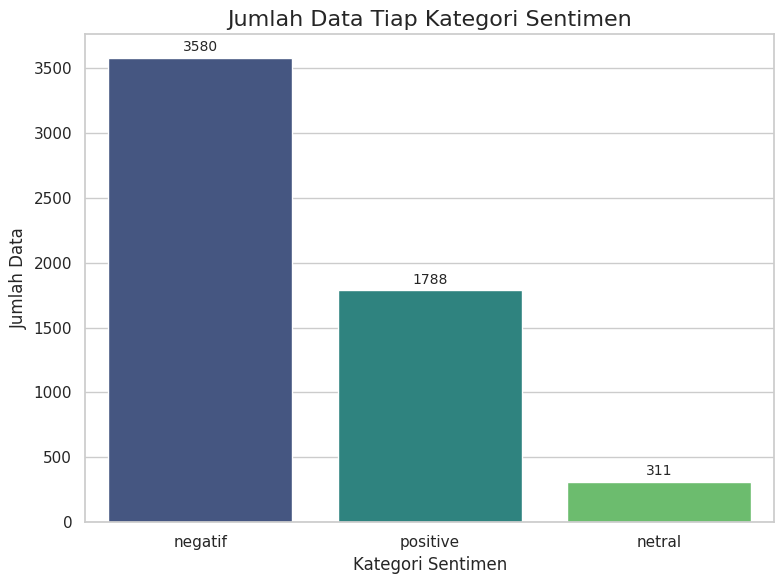

In [ ]:
sns.set(style="whitegrid")

sentiment_counts = ML_review_clean['polarity'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")

plt.title("Jumlah Data Tiap Kategori Sentimen", fontsize=16)
plt.xlabel("Kategori Sentimen", fontsize=12)
plt.ylabel("Jumlah Data", fontsize=12)
plt.xticks(rotation=0)
for i, v in enumerate(sentiment_counts.values):
    plt.text(i, v + 50, str(v), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

#### Visualisasi Word Cloud

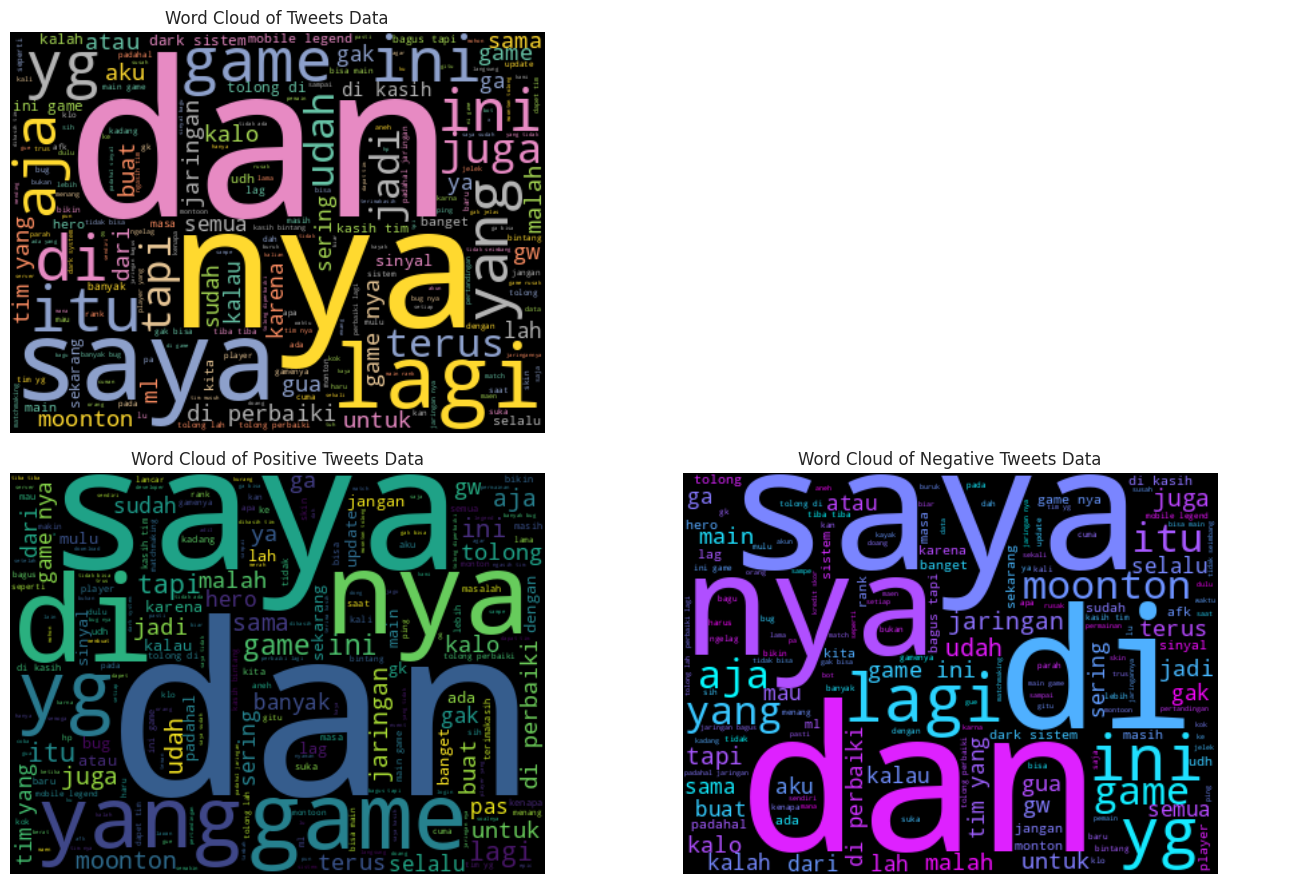

In [ ]:
ML_review_clean.to_csv('Ml_review_clean.csv', index=False)
Clean_data = pd.read_csv("/content/Ml_review_clean.csv")

Clean_data = Clean_data.dropna(subset=['text_clean', 'polarity'])

def join_text(data):
    return " ".join(str(text) for text in data)

all_text = join_text(Clean_data['text_clean'])

pos_text = join_text(Clean_data[Clean_data['polarity'] == 'positive']['text_clean'])

neg_text = join_text(Clean_data[Clean_data['polarity'] == 'negatif']['text_clean'])

wc_all = WordCloud(width=400, height=300, background_color='black', colormap='Set2').generate(all_text)
wc_pos = WordCloud(width=400, height=300, background_color='black', colormap='viridis').generate(pos_text)
wc_neg = WordCloud(width=400, height=300, background_color='black', colormap='cool').generate(neg_text)

fig, axs = plt.subplots(2, 2, figsize=(14, 9))
axs[0, 0].imshow(wc_all, interpolation='bilinear')
axs[0, 0].set_title("Word Cloud of Tweets Data")
axs[0, 1].axis('off')

axs[1, 0].imshow(wc_pos, interpolation='bilinear')
axs[1, 0].set_title("Word Cloud of Positive Tweets Data")

axs[1, 1].imshow(wc_neg, interpolation='bilinear')
axs[1, 1].set_title("Word Cloud of Negative Tweets Data")

for ax in axs.flatten():
    ax.axis('off')

plt.tight_layout()
plt.show()

### Menyimpan data yang sudah bersih ke dalam dataset berbentuk CSV

In [ ]:
ML_review_clean.to_csv('Ml_review_clean.csv', index=False)

## Estraksi Fitur dan Pelatihan Model

pada tahapan ini ada 3 model yang dikerjakan yaitu :

*   SVM Ekstraksi TF-IDF
*   RF Ekstraksi Word2Vec
*   RF Ekstraksi TF-IDF



### SVM Ekstraksi TF-IDF

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Memanggil Data yang sudah dibersihkan
clean_df = pd.read_csv('/content/Ml_review_clean.csv')

# Mapping label
label_map = {'negatif': 0, 'netral': 1, 'positif': 2}
clean_df['label'] = clean_df['polarity'].map(label_map)

clean_df.dropna(subset=['label'], inplace=True)

# Ekstraksi fitur TF-IDF
tfidf = TfidfVectorizer(max_features=3468)
clean_df.dropna(subset=['text_clean'], inplace=True)
X = tfidf.fit_transform(clean_df['text_clean']).toarray()
y = clean_df['label']

# Split data 80% train / 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Training SVM
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(X_train, y_train)

# Prediksi
y_pred_train_svm = svm_model.predict(X_train)
y_pred_test_svm = svm_model.predict(X_test)

# Evaluasi akurasi
accuracy_train_svm = accuracy_score(y_train, y_pred_train_svm)
accuracy_test_svm = accuracy_score(y_test, y_pred_test_svm)

# Tampilkan hasil
print("\nSVM - Accuracy Train:", accuracy_train_svm)
print("SVM - Accuracy Test:", accuracy_test_svm)


SVM - Accuracy Train: 0.9215938303341902
SVM - Accuracy Test: 0.920410783055199


### RF Ekstraksi Word2Vec

In [ ]:
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Load data bersih
data = pd.read_csv('/content/Ml_review_clean.csv')
label_map = {'negatif': 0, 'netral': 1, 'positif': 2}
data['label'] = data['polarity'].map(label_map)

data.dropna(subset=['label'], inplace=True)

data.dropna(subset=['text_clean'], inplace=True)
data['tokens'] = data['text_clean'].apply(nltk.word_tokenize)

sentences = [tokens for tokens in data['tokens'] if tokens]
w2v_model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=1, sg=1)


# Fungsi untuk merata-rata embedding setiap kalimat
def vector_average(tokens):
    if not tokens:
        return np.zeros(w2v_model.vector_size)
    vectors = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(w2v_model.vector_size)

# Konversi semua text jadi vektor
X_vectors = np.array([vector_average(tokens) for tokens in data['tokens']])
y = data['label']

# Split data
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(
    X_vectors, y, test_size=0.2, random_state=42, stratify=y
)

# Training Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_w2v, y_train_w2v)

y_pred_train_rf = rf_model.predict(X_train_w2v)
y_pred_test_rf = rf_model.predict(X_test_w2v)

print("Random Forest - accuracy_train:", accuracy_score(y_pred_train_rf, y_train_w2v))
print("Random Forest - accuracy_test :", accuracy_score(y_pred_test_rf, y_test_w2v))

Random Forest - accuracy_train: 1.0
Random Forest - accuracy_test : 0.9229781771501926


### RF Ekstraksi TF-IDF

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Load the cleaned data
clean_df = pd.read_csv('/content/Ml_review_clean.csv')

label_map = {'negatif': 0, 'netral': 1, 'positif': 2}
clean_df['label'] = clean_df['polarity'].map(label_map)

clean_df.dropna(subset=['label', 'text_clean'], inplace=True)

# Ekstraksi fitur TF-IDF
tfidf = TfidfVectorizer(max_features=3468)
X = tfidf.fit_transform(clean_df['text_clean']).toarray()
y = clean_df['label']

# Split data 70% train / 30% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Training Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Prediksi
y_pred_train_rf = rf_model.predict(X_train)
y_pred_test_rf = rf_model.predict(X_test)

# Evaluasi akurasi
accuracy_train_rf = accuracy_score(y_train, y_pred_train_rf)
accuracy_test_rf = accuracy_score(y_test, y_pred_test_rf)

# Tampilkan hasil
print("\nRandom Forest - Accuracy Train:", accuracy_train_rf)
print("Random Forest - Accuracy Test:", accuracy_test_rf)



Random Forest - Accuracy Train: 1.0
Random Forest - Accuracy Test: 0.9212328767123288


## Evaluasi

Pada Tahap Evaluasi ini ada beberapa yang bisa kita tangkap yaitu

1.   pada aplikasi MObile Legend banyak user yang masih kurang merasa puas pada game tersebut, dengan jumlah data negatif yang cukup besar yaitu sebanyak 3580, dimana nilai positivenya hanya setengah dari data negatif yaitu 1788

2.   Model yang memiliki akurasi yang tinggi jatuh ke pada random forest, dimana model ini sangat tinggi dalam pemodelan mulai dari menggunakan Ekstraksi Word2Vec yang mendapatkan akuarsi Pelatihan sebesar ```1.0``` dan pada test yaitu sebesar ```0.922```, dan pada Ekstraksi TF-IDF mendapatkan nilai akurasi pelatihan yaitu ```1.0``` dan Test yaitu ```0.921```